<a href="https://www.kaggle.com/code/risakashiwabara/obesity-risk-pytorch?scriptVersionId=165016896" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![https://i.postimg.cc/3wPcj7W7/Firefly-Obesity-Risk-30580.jpg](https://i.postimg.cc/3wPcj7W7/Firefly-Obesity-Risk-30580.jpg)

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import RMSprop, Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test_1 = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
display(df_train.head())
display(df_test_1.head())

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  traindata　</p>


In [3]:
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_cols:
    df_train[col] = df_train[col].map({'yes': 1, 'no': 0})
    
df_train[binary_cols].head()

df_train['CAEC'] = df_train['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

df_train['CALC'] = df_train['CALC'].map({
    'no': 0,
    'Frequently': 2,
    'Sometimes': 1
})

transport_mapping = {
    'Bike': 2,
    'Walking': 2,
    'Public_Transportation': 1,
    'Automobile': 0,
    'Motorbike': 0,
}
df_train['MTRANS'] = df_train['MTRANS'].map(transport_mapping)


df_train = pd.get_dummies(df_train, columns=['Gender'], prefix='Is', dtype='int64')
df_train.drop(columns=['Is_Male'], inplace=True)

target_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

le = LabelEncoder()
df_train['NObeyesdad'] = le.fit_transform(df_train['NObeyesdad'].map(target_mapping))

df_train['BMI'] = df_train['Weight'] / (df_train['Height'] ** 2)

df_train['bmioncp'] = df_train['BMI'] / df_train['NCP']

df_train.head()

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Is_Female,BMI,bmioncp
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,3,0,28.259565,9.472595
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,0,1,1,23.422091,7.807364
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,1,0,1,17.126706,12.132102
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,6,1,44.855798,14.951933
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,3,0,25.599151,12.984791


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class BMIBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['BMI_Category'] = pd.cut(X_copy['BMI'],
                                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')],
                                        labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'],
                                        right=False)
        X_copy.drop(columns=['BMI'], inplace=True)
        transport_mapping = {
            'Underweight':1, 
            'Normal':2,
            'Overweight':3,
            'Obesity I':4, 
            'Obesity II':5,
            'Obesity III':6}
        X_copy['BMI_Category'] = X_copy['BMI_Category'].map(transport_mapping)

        return X_copy
    

In [5]:
BMIBinner().fit_transform(df_train)

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,Is_Female,bmioncp,BMI_Category
0,0,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,3,0,9.472595,3
1,1,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,0,1,1,7.807364,2
2,2,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,1,0,1,12.132102,1
3,3,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,6,1,14.951933,6
4,4,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,3,0,12.984791,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,1,0,2.151809,0,1.330519,0.196680,1,1,5,0,12.195695,5
20754,20754,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,2,0,1.000000,0,2.000000,1.000000,1,1,0,0,4.274820,1
20755,20755,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,1,0,2.000000,0,1.158040,1.198439,0,1,5,0,10.629947,4
20756,20756,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,1,0,2.144838,0,0.000000,0.973834,0,0,3,0,14.658942,3


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  Torch　</p>

In [6]:
N_CLASSES = df_train['NObeyesdad'].nunique()
N_CLASSES

7

In [7]:
torch.manual_seed(13)
np.random.seed(13)

In [8]:
EPOCHS = 500
BATCH_SIZE = 32
LEARNING_RATE = 0.1
NUM_FEATURES = len(df_train.drop(['id', 'NObeyesdad'], axis=1).columns)

In [9]:
X = df_train.drop(['id', 'NObeyesdad'], axis=1).values
y = df_train['NObeyesdad'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=13)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# Converting From Numpy Array To Torch Tensor
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [12]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [13]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=N_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=18, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
def train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, num_epochs, train_losses, test_losses):
    print("Begin training.")
    for epoch in range(num_epochs):
    
        optimizer.zero_grad()
        output_train = model(X_train.to(device))
        loss_train = criterion(output_train, y_train.to(device))
        loss_train.backward()
        optimizer.step()

        output_test = model(X_test)
        loss_test = criterion(output_test, y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In [15]:
train_losses = np.zeros(EPOCHS)
test_losses  = np.zeros(EPOCHS)

In [16]:
train_network(model, optimizer, criterion, X_train, y_train, X_test, y_test, EPOCHS, train_losses, test_losses)

Begin training.
Epoch 50/500, Train Loss: 0.4887, Test Loss: 0.5189
Epoch 100/500, Train Loss: 0.4141, Test Loss: 0.4633
Epoch 150/500, Train Loss: 0.3837, Test Loss: 0.4504
Epoch 200/500, Train Loss: 0.3541, Test Loss: 0.4420
Epoch 250/500, Train Loss: 0.3425, Test Loss: 0.4538
Epoch 300/500, Train Loss: 0.3328, Test Loss: 0.4741
Epoch 350/500, Train Loss: 0.3102, Test Loss: 0.4377
Epoch 400/500, Train Loss: 0.2921, Test Loss: 0.4807
Epoch 450/500, Train Loss: 0.2872, Test Loss: 0.4359
Epoch 500/500, Train Loss: 0.2823, Test Loss: 0.4886


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  score　</p>

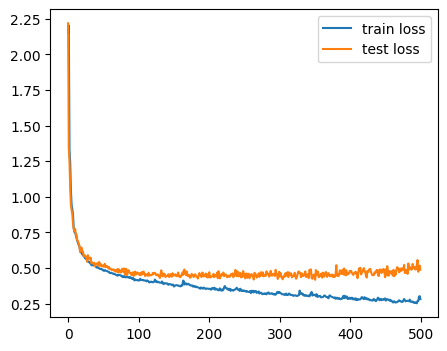

In [17]:
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [18]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train).to(device)
    predictions_test = model(X_test).to(device)

In [19]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr) != len(original_arr):
        return False
    pred_arr = pred_arr.cpu().numpy()
    original_arr = original_arr.cpu().numpy()
    final_pred = []
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

In [20]:
train_acc = get_accuracy_multiclass(predictions_train, y_train)
test_acc  = get_accuracy_multiclass(predictions_test, y_test)

print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 90.552
Test Accuracy: 85.934


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  testdata　</p>

In [21]:
df_test = df_test_1.copy()

In [22]:
def transform_test():
    global df_test
    for col in binary_cols:
        df_test[col] = df_test[col].map({'yes': 1, 'no': 0})
    df_test['CAEC'] = df_test['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

    df_test['CALC'] = df_test['CALC'].map({
        'no': 0,
        'Frequently': 2,
        'Sometimes': 1,
        'Always': 3
})
    df_test = pd.get_dummies(df_test, columns=['Gender'], prefix='Is', dtype='int64')
    df_test.drop(columns=['Is_Male'], inplace=True)
    df_test['MTRANS'] = df_test['MTRANS'].map(transport_mapping)
    df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)
    df_test['bmioncp'] = df_test['BMI'] / df_test['NCP']

In [23]:
transform_test()
BMIBinner().fit_transform(df_test)

,id,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Is_Female,bmioncp,BMI_Category
0,20758,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,1,0,2.825629,0,0.855400,0.000000,1,1,0,11.771804,5
1,20759,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,1,0,3.000000,0,1.000000,0.000000,1,1,1,25.781250,3
2,20760,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,1,0,2.621877,0,0.000000,0.250502,1,1,1,13.774705,6
3,20761,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,1,0,2.786417,0,0.094851,0.000000,1,1,0,14.431917,6
4,20762,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,1,0,2.653531,0,0.000000,0.741069,1,1,1,13.194714,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,23.327836,1.721384,78.030383,1,0,2.813234,3.000000,1,0,1.000000,0,0.807076,0.778632,1,1,0,8.777826,3
13836,34594,29.000000,1.590000,62.000000,0,1,3.000000,3.000000,1,0,2.000000,0,0.000000,0.000000,1,1,1,8.174782,2
13837,34595,22.935612,1.585547,44.376637,0,1,3.000000,2.273740,2,0,2.000000,0,1.949840,1.000000,1,1,1,7.763460,1
13838,34596,21.000000,1.620000,53.000000,1,1,2.000000,3.000000,1,0,2.000000,0,3.000000,2.000000,0,1,0,6.731697,2


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  model</p>

In [24]:
test_features = df_test.drop(['id'], axis=1).values
test_features = torch.FloatTensor(test_features).to(device)

In [25]:
predictions_final = model(test_features).to(device)

In [26]:
predicted_classes = torch.argmax(predictions_final, dim=1).cpu()

<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  Id＋target　</p>

In [27]:
final_output = pd.concat([pd.DataFrame(df_test['id']), pd.DataFrame(predicted_classes)], axis=1)
final_output.rename(columns={0: 'NObeyesdad'}, inplace=True)

final_output.head()

,id,NObeyesdad
0,20758,5
1,20759,2
2,20760,6
3,20761,4
4,20762,6


In [28]:
target_mapping_rev = {target_mapping[k] : k for k in target_mapping}
target_mapping_rev

{0: 'Insufficient_Weight',
 1: 'Normal_Weight',
 2: 'Overweight_Level_I',
 3: 'Overweight_Level_II',
 4: 'Obesity_Type_I',
 5: 'Obesity_Type_II',
 6: 'Obesity_Type_III'}

In [29]:
final_output['NObeyesdad'] = final_output['NObeyesdad'].map(target_mapping_rev)

In [30]:
final_output

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Insufficient_Weight


<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/906LHB59/gahag-0065972645-1.jpg);font-family:camtasia;font-size:120%;color:White;text-align:center;border-radius:15px 50px; padding:7px">  submit　</p>

In [31]:
final_output.to_csv('submission.csv', index=False)